## Pytorch code percolation model with Ohtsuki CNN

## parameter choices

In [1]:
myseed=111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size=512
num_epochs=10
# mylr= 0.01
# mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)
# path='../../../../../../../media/phrhmb/Datasets_DisQS/'+dataname
# path='/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname
datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
#datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home RAR

method='PyTorch-resnet50-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
print(dataname,"\n",datapath,"\n",method)

modelname = '/Model_'+method+'_'+dataname+'.pth'
modelpath = datapath+modelname
historyname = '/History_'+method+'_'+dataname+'.pkl'
historypath = datapath+historyname
print(method,"\n",modelname,"\n",historyname)

#PATH = './Anderson_'+dataname+'_resnet50_'+str(num_epochs)+'_epochs_batch_size'+str(batch_size)+'.pth'

L20-100-s100 
 /storage/disqs/ML-Data/Anderson/Images/L20-100-s100 
 PyTorch-resnet50-111111-e10
PyTorch-resnet50-111111-e10 
 /Model_PyTorch-resnet50-111111-e10_L20-100-s100.pth 
 /History_PyTorch-resnet50-111111-e10_L20-100-s100.pkl


## initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#seed=42
import torch
torch.manual_seed(myseed)
import numpy as np
np.random.seed(myseed+1)

In [4]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.4.0
sklearn version: 0.21.3


In [5]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import os
import copy

In [6]:
t=torch.Tensor()
print('current device: ', t.device, t.dtype, t.layout)

# switch to GPU if available
device=t.device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print('chosen device: ',device)

current device:  cpu torch.float32 torch.strided
chosen device:  cuda:0


## starting the main code

In [7]:
# img_sizeX= 100
# img_sizeY= 100 #img_sizeX
# validation_split= 0.1

In [8]:
class MyImageFolder2(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(MyImageFolder2, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [10]:
training_set=0
validation_set=0
# dataname='L20-100-s100'
# path='../../../../../../../media/phrhmb/Datasets_DisQS/'+dataname
# path='/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname

transform=transforms.Compose([torchvision.transforms.Resize((32,32)),
                              torchvision.transforms.ToTensor()])

In [11]:
os.getcwd()

'/home/physics/phsht/Projects/MachineLearning-Anderson/src'

In [12]:
#path = datapath 
whole_dataset=MyImageFolder2(root=datapath, transform=transform)

In [13]:
data_size = len(whole_dataset)
# validation_split=0.1
split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
# split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))

In [14]:
# batch_size=1024
train = torch.utils.data.DataLoader(
        dataset=training_set,
        batch_size=batch_size,
        shuffle=True)

val = torch.utils.data.DataLoader(
        dataset=validation_set,
        batch_size=batch_size,
        shuffle=False)

In [15]:
class_names =whole_dataset.classes
class_names

['W15.0',
 'W15.25',
 'W15.5',
 'W15.75',
 'W16.0',
 'W16.2',
 'W16.3',
 'W16.4',
 'W16.5',
 'W16.6',
 'W16.7',
 'W16.8',
 'W17.0',
 'W17.25',
 'W17.5',
 'W17.75',
 'W18.0']

In [16]:
inputs,labels,path= next(iter(val))

In [17]:
inputs.shape

torch.Size([170, 3, 32, 32])

In [18]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

32

In [19]:
labels.shape

torch.Size([170])

In [20]:
num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
number_classes = len(class_names)
print('number of samples in the training set:', num_of_train_samples)
print('number of samples in the validation set:', num_of_test_samples )
print('number of samples in a batch',len(train)) 
print('number of samples in a batch',len(val))
print('number of classes',number_classes )

number of samples in the training set: 1530
number of samples in the validation set: 170
number of samples in a batch 3
number of samples in a batch 1
number of classes 17


## building the CNN

In [21]:
model=models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features # number of input features of the last layer which is fully connected (fc)

#We modify the last layer in order to have 2 output: percolating or not
model.fc=nn.Linear(num_ftrs, number_classes )
 #the model is sent to the GPU
model = model.to(device)

In [22]:
# defining the optimizer

optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
# defining the loss function
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [24]:
# for param in model.parameters():
#     print(param.shape)

In [25]:
#the model is sent to the GPU
model = model.to(device)

In [26]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    global accuracy, _loss, val_accuracy, val_loss, epochs, val_epochs 
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy=[]
    _loss=[]
    val_accuracy=[]
    val_loss=[]
    epochs=[]
    val_epochs=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                print('Training', end=" ")
                model.train() # set the model to training mode
            else:
                print('Validation', end=" ")
                model.eval() # set the model to evaluation mode
                
            batches= len(list(enumerate(phase)))
            print('with', batches, 'batches')
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            # print('--- iterating through data ...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                
                print(i*100//batches, '%', end="\r", flush=True)
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()            
            
            if phase == train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss= {:4f}, accuracy= {:4f}'.format(
                    'Training result:', epoch_loss, epoch_acc))
                accuracy.append(epoch_acc)
                _loss.append(epoch_loss)
                epochs.append(epoch)
                
            if phase == val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss= {:4f}, val_accuracy= {:4f}'.format(
                    'Validation result:', epoch_loss, epoch_acc))
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                val_epochs.append(epoch)
                
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model        

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):

            inputs=inputs.to(device)
            labels=labels.to(device)

            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                imshow(inputs.cpu().data[j])
                
                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
def visualize_model_misclassified(model, num_images=6): #gives shows only the misclassified images
    import re
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                if labels[j]!=preds[j] and abs(labels[j]-preds[j])>4:
                #print(inputs.size()[0])
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                    imshow(inputs.cpu().data[j])
                
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        
        model.train(mode=was_training)

In [29]:
# num_epochs=10
base_model = train_model(
    model, criterion, optimizer,num_epochs,exp_lr_scheduler,batch_size=batch_size )

Epoch 1/10
----------
Training with 3 batches
Training result: loss= 3.235113, accuracy= 0.066013
Validation with 1 batches
Validation result: val_loss= 1074.580566, val_accuracy= 0.094118

Epoch 2/10
----------
Training with 3 batches
Training result: loss= 3.188088, accuracy= 0.077778
Validation with 1 batches
Validation result: val_loss= 55.429245, val_accuracy= 0.082353

Epoch 3/10
----------
Training with 3 batches
Training result: loss= 2.881857, accuracy= 0.120261
Validation with 1 batches
Validation result: val_loss= 12.198199, val_accuracy= 0.035294

Epoch 4/10
----------
Training with 3 batches
Training result: loss= 2.819885, accuracy= 0.145752
Validation with 1 batches
Validation result: val_loss= 2.752684, val_accuracy= 0.100000

Epoch 5/10
----------
Training with 3 batches
Training result: loss= 2.737881, accuracy= 0.163399
Validation with 1 batches
Validation result: val_loss= 2.769573, val_accuracy= 0.076471

Epoch 6/10
----------
Training with 3 batches
Training resul

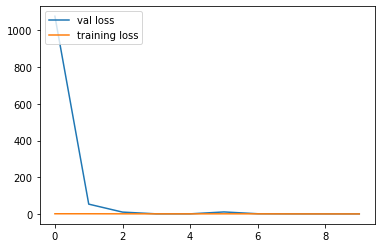

In [30]:
fig=plt.figure()
plt.plot(epochs,val_loss, label='val loss')
plt.plot(epochs,_loss, label='training loss')
plt.legend(loc='upper left')
fig.savefig(datapath+'/'+method+'_'+dataname+'_loss'+'.png')

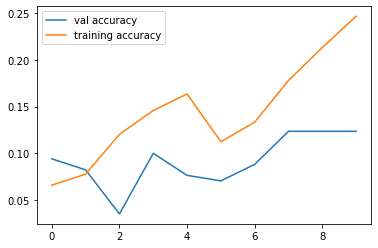

In [31]:
fig=plt.figure()
plt.plot(val_epochs,val_accuracy, label='val accuracy')
plt.plot(epochs,accuracy, label='training accuracy')
plt.legend(loc='upper left')
fig.savefig(datapath+'/'+method+'_'+dataname+'_accuracy'+'.png')

In [32]:
# PATH = './Anderson_'+dataname+'_resnet50_'+str(num_epochs)+'_epochs_batch_size'+str(batch_size)+'.pth'
torch.save(model.state_dict(), modelpath)

## testing the quality of the learned model

Accuracy of W15.0 :  0 %
Accuracy of W15.25 : 72 %
Accuracy of W15.5 :  8 %
Accuracy of W15.75 :  0 %
Accuracy of W16.0 :  0 %
Accuracy of W16.2 :  0 %
Accuracy of W16.3 :  0 %
Accuracy of W16.4 :  0 %
Accuracy of W16.5 :  0 %
Accuracy of W16.6 :  0 %
Accuracy of W16.7 : 21 %
Accuracy of W16.8 :  0 %
Accuracy of W17.0 :  8 %
Accuracy of W17.25 : 16 %
Accuracy of W17.5 : 14 %
Accuracy of W17.75 : 12 %
Accuracy of W18.0 : 44 %
17


<Figure size 432x288 with 0 Axes>

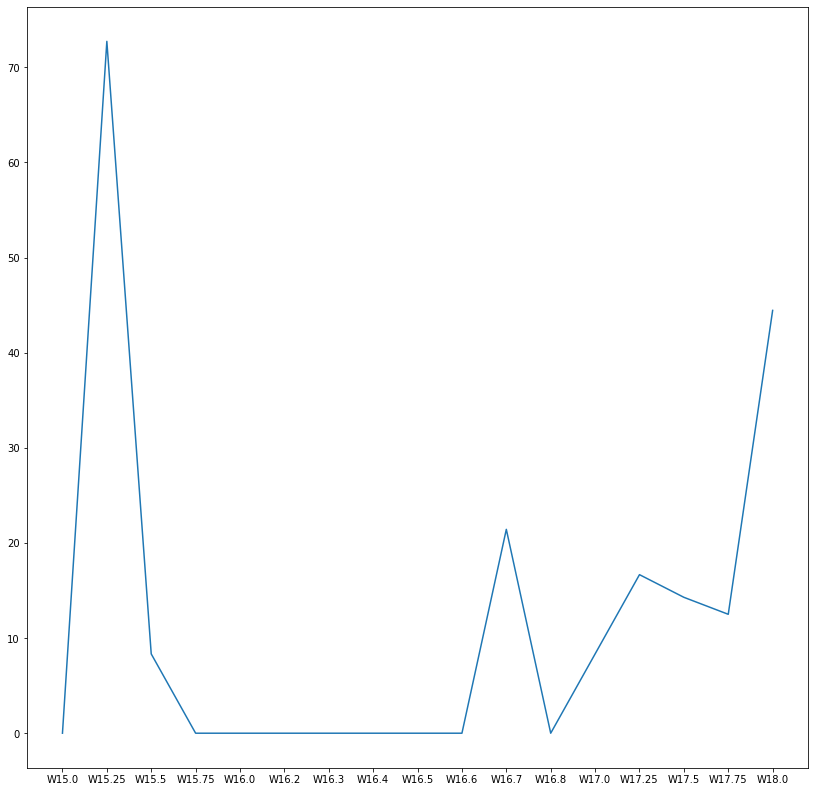

In [33]:
class_correct = list(0. for i in range(number_classes))
class_total = list(0. for i in range(number_classes))
accuracy=list(0. for i in range(number_classes))
average=list(0. for i in range(number_classes))
with torch.no_grad():
     for i, (data) in enumerate(val):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 

        c = (preds == labels).squeeze()
        for i in range(inputs.size()[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(number_classes):
    average[i]=(class_correct[i] / class_total[i])*100
    
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

print(len(average))
fig=plt.figure()
plt.figure(figsize=(14,14))
plt.plot(class_names,average)
fig.savefig(datapath+'/'+method+'_'+dataname+'_classacc'+'.png')

In [34]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                
    return confusion_matrix

In [35]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
          0.,  0.,  1.],
        [ 0.,  5.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,
          0.,  0.,  0.],
        [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  1.,
          0.,  0.,  0.],
        [ 0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
          0.,  0.,  1.],
        [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.],
        [ 0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
          0.,  1.,  1.],
        [ 0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,
          0.,  1.,  3.],
        [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
          0.,  1.,  1.],
        [ 0.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 

In [36]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)#,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 

    fig=plt.figure()
    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
#     plt.show()
    plt.savefig(datapath+'/'+method+'_'+dataname+'_CM'+'.png')
    plt.show()

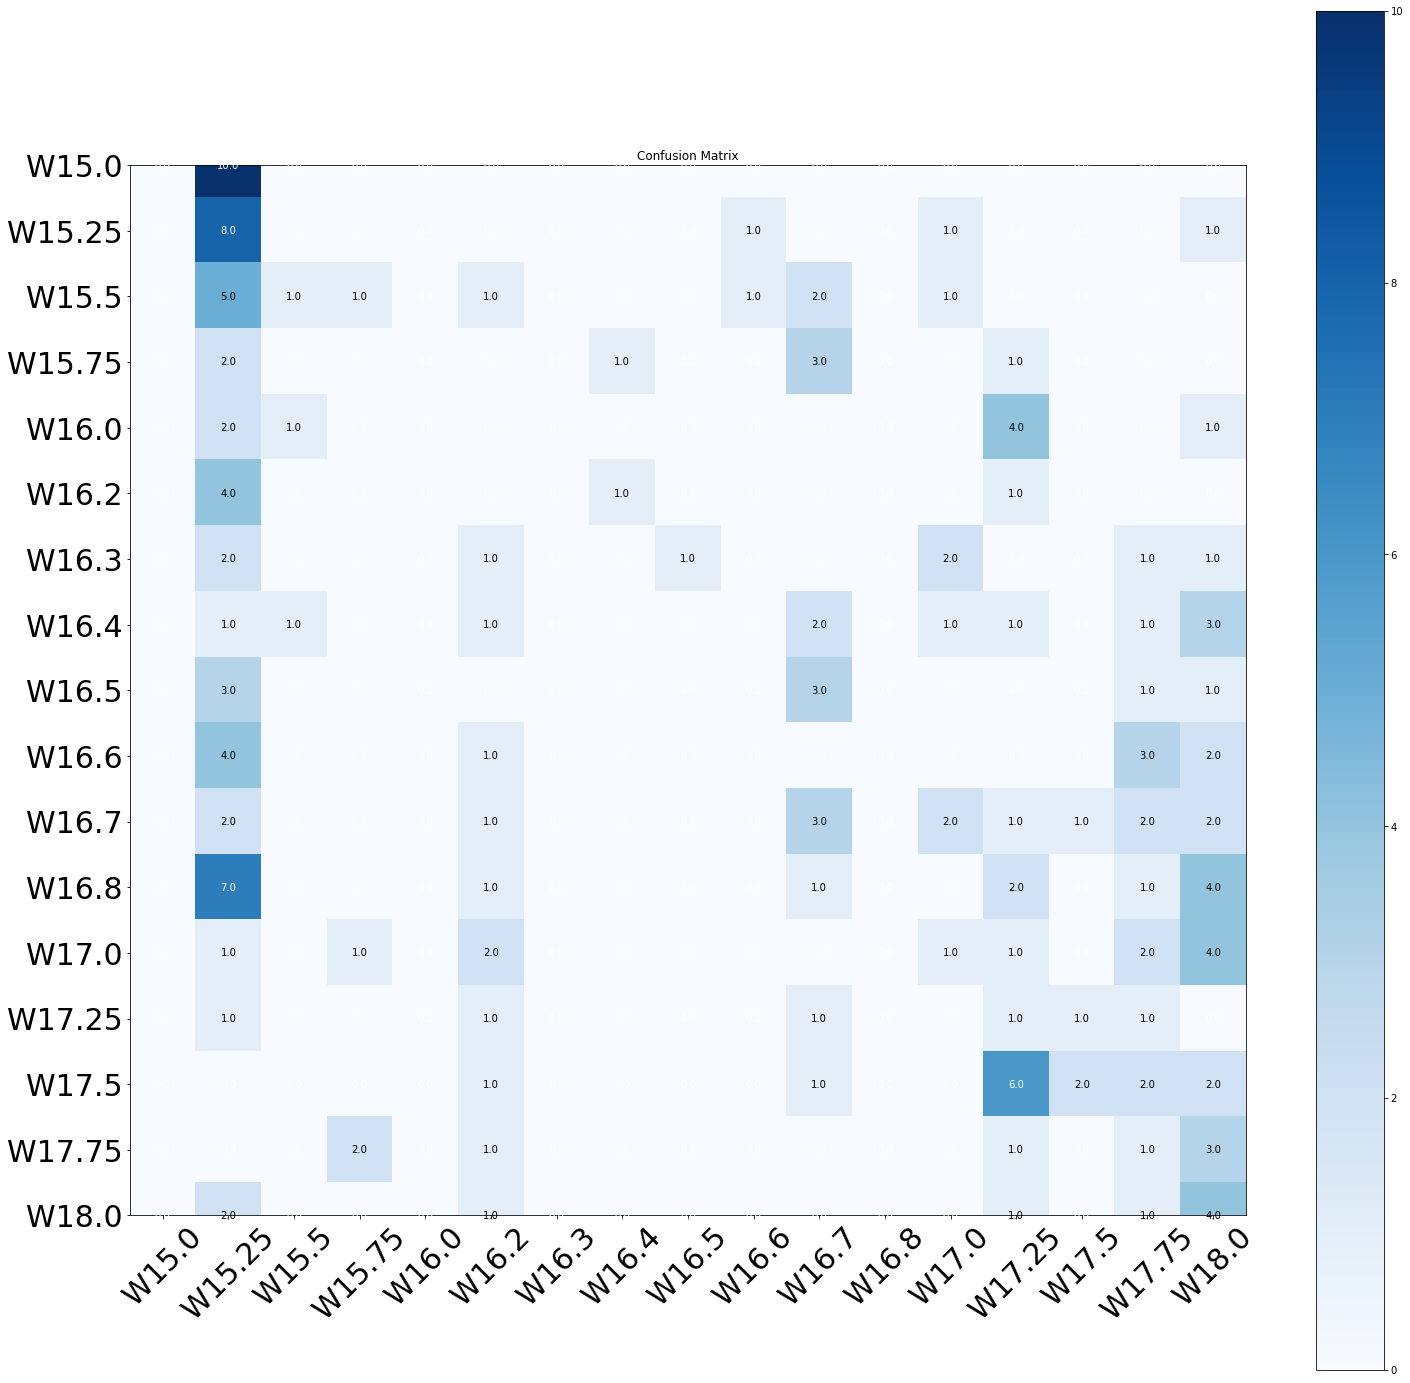

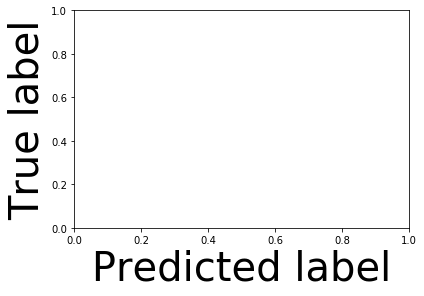

In [37]:
confusion_matrix_torch(cm,class_names)